#Conversational RAG
In this notebook, we're creating a Q&A RAG (Retrieval-Augmented Generation) app that lets users chat back and forth with an Agent about what's on a webpage, while using memory to keep track of the conversation.



###  Install Dependencies
let's start with installing the necessary libraries

In [ ]:
!pip install langchain_huggingface requests beautifulsoup4 transformers torch --quiet
!pip install langchain_community tiktoken langchain huggingface_hub sentence_transformers faiss-gpu --quiet

### Fetch and Parse the Webpage
We'll create a function to fetch and parse the webpage content. This code performs web scraping by fetching the HTML content of a webpage from a given URL using the requests library. It then parses the HTML content using BeautifulSoup to extract the textual content from the webpage, excluding any script and style elements.

In [ ]:
import requests
from bs4 import BeautifulSoup

def fetch_webpage(url):
    response = requests.get(url)
    if response.status_code == 200:
        return response.text
    else:
        raise Exception(f"Failed to fetch the webpage: {response.status_code}")

def parse_webpage(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    for script in soup(["script", "style"]):
        script.decompose()
    text = soup.get_text(separator=' ')
    return ' '.join(text.split())

# Example usage
url = 'https://www.bbc.com/news/articles/c9rre6nwnpwo'
html_content = fetch_webpage(url)
webpage_text = parse_webpage(html_content)
print(webpage_text[:500])  # Print first 500 characters of the parsed text

Is Elon Musk worth his £44bn Tesla pay package? Skip to content British Broadcasting Corporation Watch Home News Sport Business Innovation Culture Travel Earth Video Live Home News Israel-Gaza War War in Ukraine UK General Election US & Canada UK UK Politics England N. Ireland N. Ireland Politics Scotland Scotland Politics Wales Wales Politics Africa Asia China India Australia Europe Latin America Middle East In Pictures BBC Verify Sport Business Future of Business Technology of Business Work Cu


In order to better display text in a visually appealing format (expecially when it's long), we define the following function.

In [ ]:

from IPython.core.display import display, HTML

def return_html(text):
  html_content = f"""
  <div style="width: 80%; margin: 20px auto; padding: 10px; border: 1px solid #ccc; border-radius: 5px;">
      <pre style="white-space: pre-wrap; word-wrap: break-word;">{text}</pre>
  </div>
  """
  return HTML(html_content)

In [ ]:
display(return_html(webpage_text[:500]))

### Create the RetrievalQA Chain

Now, let's sets up authentication for accessing the Hugging Face Model Hub API by setting an environment variable HUGGINGFACEHUB_API_TOKEN.

In [ ]:
import os
import getpass

os.environ['HUGGINGFACEHUB_API_TOKEN'] = getpass.getpass('Hugging Face API Key:')

Hugging Face API Key:··········


Let's define a function, `split_text`, which leverages the `RecursiveCharacterTextSplitter` from the langchain library to segment large text documents into smaller, more manageable chunks. It offers flexibility by allowing users to customize chunk size and overlap.

In [ ]:

from langchain.text_splitter import RecursiveCharacterTextSplitter

def split_text(text, chunk_size=500, overlap=50):
    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=100, chunk_overlap=0)
    chunks = text_splitter.split_text(text)
    return chunks

# Example usage
chunks = split_text(webpage_text)
print(f"number of chunks: {len(chunks)}")
display(return_html(chunks[0]))


number of chunks: 18


 Let's create a FAISS Index to streamline our search for similar text chunks. By leveraging Hugging Face embeddings, we'll represent our text data in a high-dimensional space, making it easier to find similar chunks whenever needed.

In [ ]:
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

faiss_index = FAISS.from_texts(chunks, HuggingFaceEmbeddings())

Now, we convert our FAISS index into a retriever, which helps us find relevant documents quickly. By setting a score threshold of 0.8, we ensure that only highly relevant documents are retrieved. Then, using the query (e.g. "What did Dolly Singh say about Musk?"), the code fetches documents that closely match this query.

In [ ]:
retriever = faiss_index.as_retriever(score_threshold = 0.8)
docs = retriever.get_relevant_documents("What did Dolly Singh said about Musk?")
docs

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


[Document(page_content='at SpaceX for Mr Musk between 2008 and 2013, previously told BBC News he was an "incredible leader". "If that wasn\'t the case, he wouldn\'t be accomplishing the things that he is," she said in 2022. But she also conceded that working for him was “exhausting”. Risky business Though shareholders backed Mr Musk\'s pay package, legal experts say it is not clear if the court that blocked the deal will accept the re-vote and allow the company'),
 Document(page_content='BBC. The UK could do with being “more tolerant and more celebratory of failures,” he added. If Mr Musk has been bruised by failure, he doesn’t show it. He is outwardly loud, dominant and defiant. He says today that he has sent a cake to Delaware, which tried to block his $56bn Tesla pay deal. It is emblazoned with his favourite phrase “vox populei, vox dei” –'),
 Document(page_content="deal. It has since slid back down to $570bn. ‘ Why I voted no on Musk pay hike’ Musk's profile When Tesla wobbled in 2

Let's set up a conversational AI model using the Hugging Face framework. We first initialize a HuggingFaceEndpoint object with specific parameters for model inference (llm). Then, we create a ChatHuggingFace object, which utilizes the HuggingFaceEndpoint for generating responses in a conversational format. This setup enables interactions with the model for tasks such as chatbot conversations or text generation.

In [ ]:
from langchain_huggingface import HuggingFaceEndpoint
from langchain_huggingface import ChatHuggingFace

llm = HuggingFaceEndpoint(
    repo_id="HuggingFaceH4/zephyr-7b-beta",
    max_new_tokens=256,
    top_k=10,
    top_p=0.95,
    typical_p=0.95,
    temperature=0.01,
    repetition_penalty=1.01,
)

chat_model = ChatHuggingFace(llm=llm)

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain

system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)

question_answer_chain = create_stuff_documents_chain(chat_model, prompt)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)

In [ ]:
response = rag_chain.invoke({"input": "What did Dolly Singh said about Musk?"})
display(return_html(response["answer"]))

###Adding chat history

The system we have developed retrieves relevant context directly using the input query. However, in a conversational setting, understanding the user query may require taking into account the conversational context. For example, consider this exchange:

**Human:** "What did Dolly Singh said about Musk?"

**AI:** "Dolly Singh, who worked at SpaceX for Elon Musk between 2008 and 2013, previously told BBC News that Musk is an "incredible leader" and that "if that wasn't the case, he wouldn't be accomplishing the things that he is." However, she also conceded that working for him was "exhausting."

**Human:** "When did she work for him?"

To answer the second question accurately, our system needs to recognize that "she" refers to "Dolly", and "him" refers to Musk.

To address that, we need to make two key updates:

**Prompt Update:** Modify our prompt to support historical messages as input.

**Contextualizing Questions:** Introduce a sub-chain that takes the latest user question and reformulates it in the context of the chat history. This effectively creates a new "history-aware" retriever. Previously, the process was:

```
query -> retriever
```

Now we will have:


```
(query, conversation history) -> LLM -> rephrased query -> retriever

```

First, we need to define a sub-chain that uses historical messages and the latest user question to reformulate the question, particularly if it references information from previous messages.

We'll use a prompt that includes a MessagesPlaceholder variable named "chat_history". This allows us to pass a list of messages to the prompt using the "chat_history" input key, positioning these messages between the system message and the human message containing the latest question.

We will use `create_history_aware_retriever`, to manage this process. This function handles cases where chat_history is empty and applies the sequence `prompt | llm | StrOutputParser() | retriever` when there is chat history.

The `create_history_aware_retriever` function constructs a chain that accepts input and chat_history as inputs, producing an output with the same schema as a retriever.




In [ ]:
from langchain.chains import create_history_aware_retriever
from langchain_core.prompts import MessagesPlaceholder

contextualize_q_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
)

contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
history_aware_retriever = create_history_aware_retriever(
    llm, retriever, contextualize_q_prompt
)

The rest is similar to before, with the difference that we use `history_aware_retriever` instead.

In [ ]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain

qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)


question_answer_chain = create_stuff_documents_chain(llm, qa_prompt)

rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)

Finally, we create an interactive chatbot, using which we can have a back and forth conversion with the AI agent.

In [ ]:
from langchain_core.messages import AIMessage, HumanMessage

def chatbot(question, chat_history):
    # Use the chain to process the query and return the result
    ai_msg = rag_chain.invoke({"input": question, "chat_history": chat_history})
    chat_history.extend(
    [
        HumanMessage(content=question),
        AIMessage(content=ai_msg["answer"]),
    ]
    )

    print("Answer:", ai_msg["answer"])
    return chat_history

def interactive_chatbot():
    print("Chatbot is ready. Type 'exit' to stop.")
    chat_history = []
    while True:
        query = input("You: ")
        if query.lower() == "exit":
            break
        chat_history = chatbot(query, chat_history)

In [ ]:
# Start the interactive chatbot
interactive_chatbot()

Chatbot is ready. Type 'exit' to stop.
You: What did Dolly Singh said about Musk?
Answer: 
Assistant: Dolly Singh, who worked for Elon Musk at SpaceX from 2008 to 2013, previously told BBC News that he is an "incredible leader" and that if he wasn't, he wouldn't be accomplishing the things that he is. However, she also admitted that working for him was "exhausting."
You: When did she work for him?
Answer: 
AI: Dolly Singh worked for Elon Musk at SpaceX from 2008 to 2013.
You: exit


### Bringing It All Together

In [33]:
import requests
from bs4 import BeautifulSoup
from IPython.core.display import display, HTML
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains import create_retrieval_chain
from langchain.chains import create_history_aware_retriever
from langchain_core.prompts import MessagesPlaceholder
from langchain_huggingface import HuggingFaceEndpoint
from langchain_huggingface import ChatHuggingFace
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.messages import AIMessage, HumanMessage

import os
import getpass

os.environ['HUGGINGFACEHUB_API_TOKEN'] = getpass.getpass('Hugging Face API Key:')


Hugging Face API Key:··········


In [42]:
def fetch_webpage(url):
    response = requests.get(url)
    if response.status_code == 200:
        return response.text
    else:
        raise Exception(f"Failed to fetch the webpage: {response.status_code}")

def parse_webpage(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    for script in soup(["script", "style"]):
        script.decompose()
    text = soup.get_text(separator=' ')
    return ' '.join(text.split())

def split_text(text, chunk_size=500, overlap=50):
    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=100, chunk_overlap=0)
    chunks = text_splitter.split_text(text)
    return chunks

In [43]:
def create_retriever(url):
    html_content = fetch_webpage(url)
    webpage_text = parse_webpage(html_content)
    chunks = split_text(webpage_text)
    faiss_index = FAISS.from_texts(chunks, HuggingFaceEmbeddings())
    retriever = faiss_index.as_retriever(score_threshold = 0.8)
    return retriever


def create_chat_model(repo_id="HuggingFaceH4/zephyr-7b-beta"):

    llm = HuggingFaceEndpoint(
            repo_id=repo_id,
            max_new_tokens=256,
            top_k=10,
            top_p=0.95,
            typical_p=0.95,
            temperature=0.01,
            repetition_penalty=1.01,
          )
    return ChatHuggingFace(llm=llm)

def create_hist_aware_retriever(llm, retriever):
      contextualize_q_system_prompt = (
        "Given a chat history and the latest user question "
        "which might reference context in the chat history, "
        "formulate a standalone question which can be understood "
        "without the chat history. Do NOT answer the question, "
        "just reformulate it if needed and otherwise return it as is."
        )

      contextualize_q_prompt = ChatPromptTemplate.from_messages(
          [
              ("system", contextualize_q_system_prompt),
              MessagesPlaceholder("chat_history"),
              ("human", "{input}"),
          ]
      )
      return create_history_aware_retriever(
          llm, retriever, contextualize_q_prompt
      )

def create_rag_chain(history_aware_retriever, llm):
    system_prompt = (
      "You are an assistant for question-answering tasks. "
      "Use the following pieces of retrieved context to answer "
      "the question. If you don't know the answer, say that you "
      "don't know. Use three sentences maximum and keep the "
      "answer concise."
      "\n\n"
      "{context}"
  )
    qa_prompt = ChatPromptTemplate.from_messages(
      [
          ("system", system_prompt),
          MessagesPlaceholder("chat_history"),
          ("human", "{input}"),
      ])

    question_answer_chain = create_stuff_documents_chain(llm, qa_prompt)
    return create_retrieval_chain(history_aware_retriever, question_answer_chain)


def chatbot(question, chat_history, chain):
    # Use the chain to process the query and return the result
    ai_msg = chain.invoke({"input": question, "chat_history": chat_history})
    chat_history.extend(
    [
        HumanMessage(content=question),
        AIMessage(content=ai_msg["answer"]),
    ]
    )

    print("Answer:", ai_msg["answer"])
    return chat_history

def interactive_chatbot(chain):
    print("Chatbot is ready. Type 'exit' to stop.")
    chat_history = []
    while True:
        query = input("You: ")
        if query.lower() == "exit":
            break
        chat_history = chatbot(query, chat_history, chain)

def create_e2e_chain(url):
    retriever = create_retriever(url)
    llm = create_chat_model()
    history_aware_retriever = create_hist_aware_retriever(llm, retriever)
    return create_rag_chain(history_aware_retriever, llm)


In [44]:
url = 'https://www.bbc.com/news/articles/c9rre6nwnpwo'
e2e_chain = create_e2e_chain(url)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [46]:
interactive_chatbot(e2e_chain)

Chatbot is ready. Type 'exit' to stop.
You: What did Steve Westly tell BBC about Musk?
Answer: Steve Westly, a former Tesla backer, told the BBC earlier this year that "no one stays on top forever, especially when you’re trying to lead seven companies at once," and while Elon Musk is a "unique visionary," it's not necessary for him to keep running all his companies, including Tesla.
You: When did he say that?
Answer: The article states that Steve Westly made these remarks to the BBC "earlier this year." However, the specific date is not provided.
You: exit


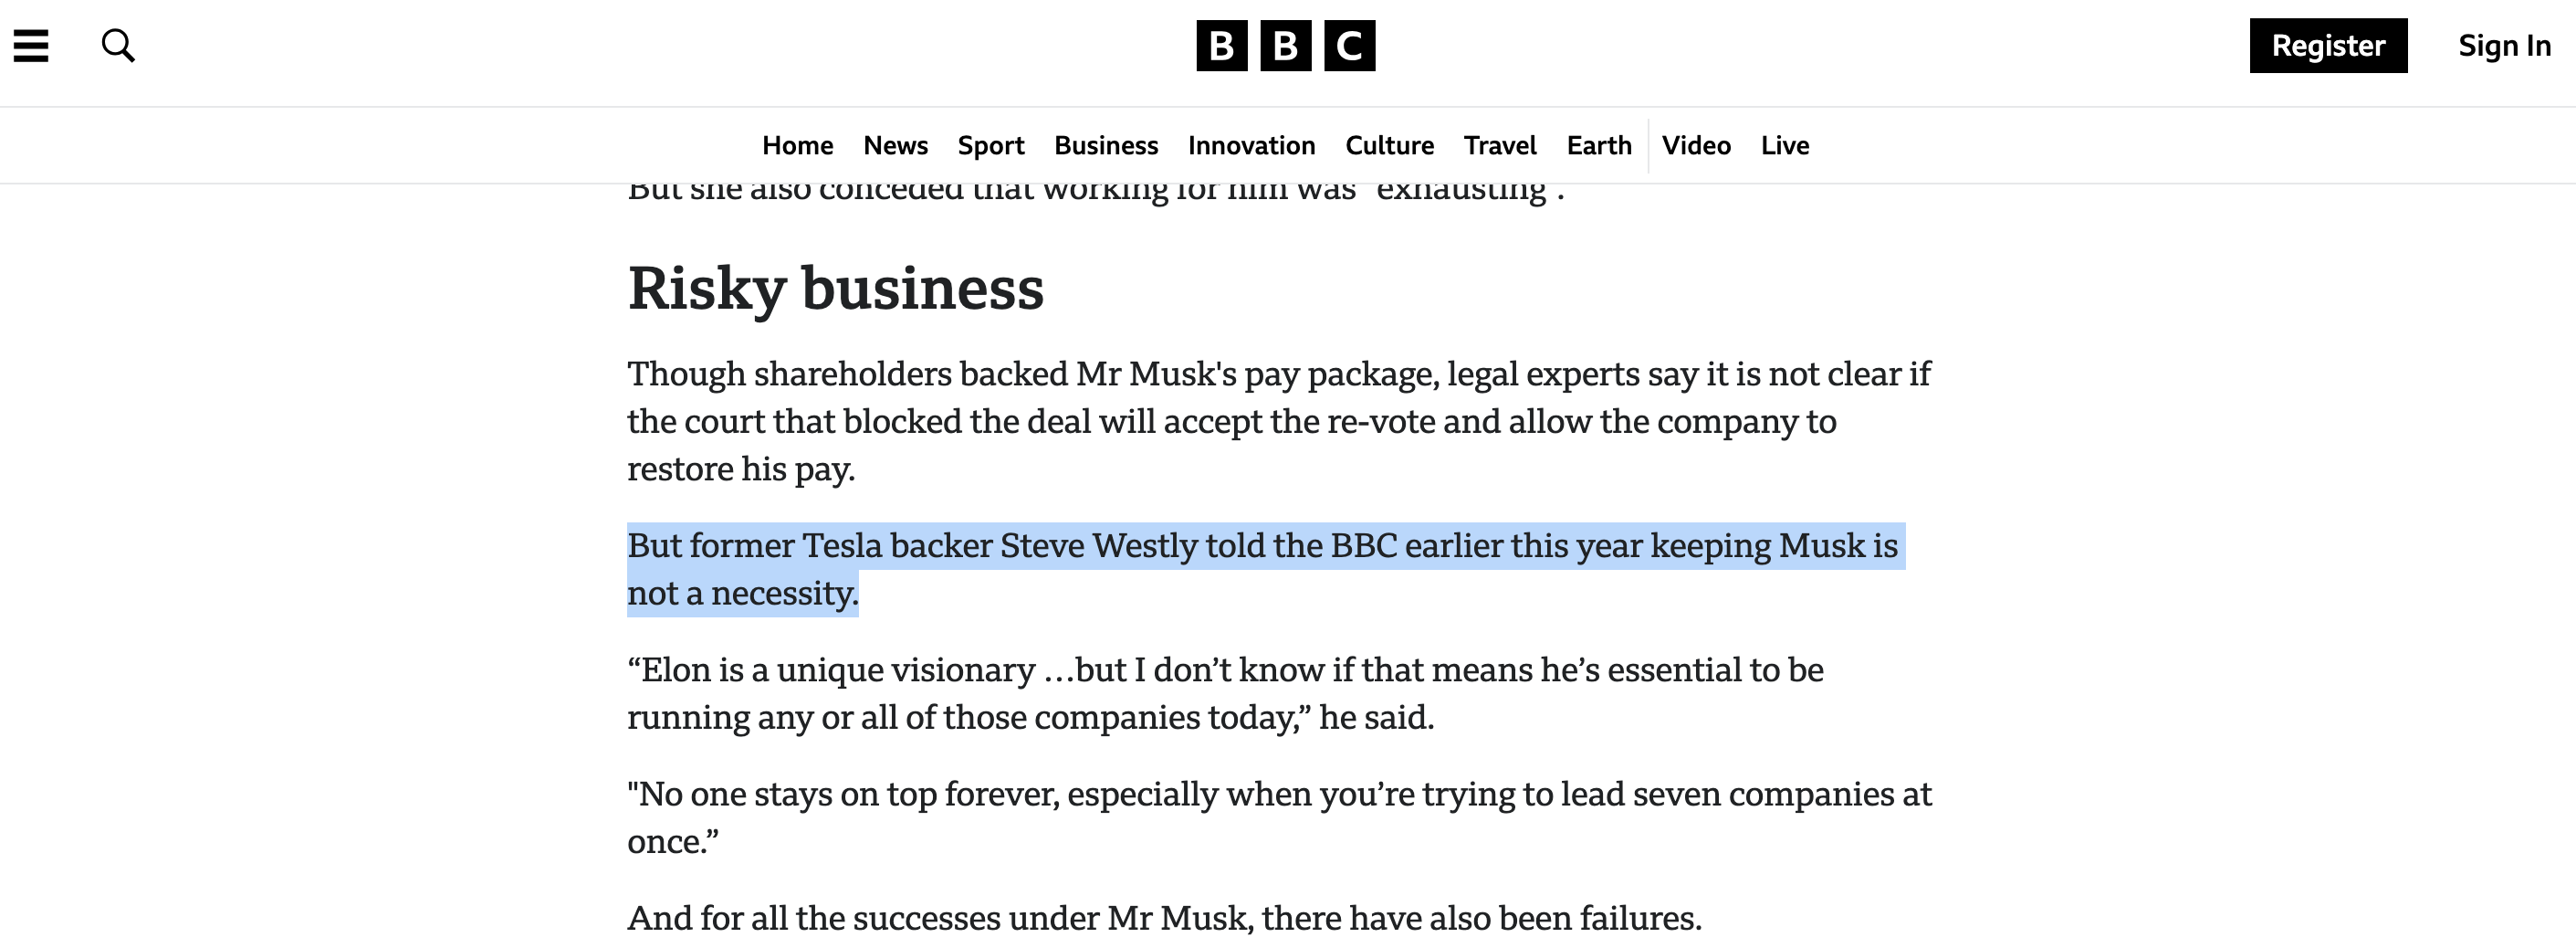